In [1]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image, ImageChops,ImageEnhance
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import random
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
# Paths to cg1050 dataset
train_original_path = '/kaggle/input/cg1050/TRAINING_CG-1050/TRAINING/ORIGINAL/*'
train_tampered_path = '/kaggle/input/cg1050/TRAINING_CG-1050/TRAINING/TAMPERED/*'
val_original_path = '/kaggle/input/cg1050/VALIDATION_CG-1050/VALIDATION/ORIGINAL/*'
val_tampered_path = '/kaggle/input/cg1050/VALIDATION_CG-1050/VALIDATION/TAMPERED/*'
#paths to CASIA 2 dataset 
AU_CASA2='/kaggle/input/casia-dataset/CASIA2/Au/*'
TP_CASA2= '/kaggle/input/casia-dataset/CASIA2/Tp/*'

In [3]:
# this collect all file paths that match a specified pattern , in the code  I got it use random sample 
train_original_files = glob(train_original_path)
train_tampered_files = glob(train_tampered_path)
val_original_files = glob(val_original_path)
val_tampered_files = glob(val_tampered_path)
AU_CASA2_files= glob(AU_CASA2)
TP_CASA2_files= glob(TP_CASA2)

AU_files= AU_CASA2_files + train_original_files + val_original_files
TP_files= TP_CASA2_files + train_tampered_files + val_tampered_files

In [4]:
def convert_to_ela_image(image, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    

    image = image.convert('RGB')

    
    
    image.save(temp_filename, 'JPEG', quality=quality)
    
    # Reload the saved image
    resaved_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, resaved_image)
    
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


In [5]:
def prepare_image(image, quality=91, image_size=(256,256)):
    ela_image = convert_to_ela_image(image, quality)
    ela_image = ela_image.convert("L")
    ela_image = ela_image.resize(image_size)
    return np.array(ela_image).flatten() / 255.0

In [6]:
X=[]
Y=[]
for image_path in TP_files:
    if image_path.endswith('jpg') or image_path.endswith('png'):
        image = Image.open(image_path)
        image= prepare_image(image)
        X.append(image)
        Y.append(0) 
    elif not image_path.endswith('Thumbs.db'):
        image = Image.open(image_path)
        png_path = '/kaggle/working/' + image_path.rsplit('/', 1)[1].rsplit('.', 1)[0] + '.png'
        image.save(png_path, 'PNG')
        image = Image.open(png_path)
        image = prepare_image(image)
        X.append(image)
        Y.append(0)
          
        
        
    if len(Y) % 50 == 0:
            print(f'Processing {len(Y)} images')
     

print(len(X), len(Y))


for image in AU_files:
    if image.endswith('jpg') or image.endswith('png'):
        image = Image.open(image)
        image= prepare_image(image)
        X.append(image)
        Y.append(1)
    if len(Y) % 500 == 0:
            print(f'Processing {len(Y)} images')
    if len(Y) == 12334:
        break

print(len(X), len(Y))

Processing 50 images
Processing 100 images
Processing 150 images
Processing 200 images
Processing 250 images
Processing 300 images
Processing 350 images
Processing 400 images
Processing 450 images
Processing 500 images
Processing 550 images
Processing 600 images
Processing 650 images
Processing 700 images
Processing 750 images
Processing 800 images
Processing 850 images
Processing 900 images
Processing 950 images
Processing 1000 images
Processing 1050 images
Processing 1100 images
Processing 1150 images
Processing 1200 images
Processing 1250 images
Processing 1300 images
Processing 1350 images
Processing 1400 images
Processing 1450 images
Processing 1500 images
Processing 1550 images
Processing 1600 images
Processing 1650 images
Processing 1700 images
Processing 1750 images
Processing 1800 images
Processing 1850 images
Processing 1900 images
Processing 1950 images
Processing 2000 images
Processing 2050 images
Processing 2100 images
Processing 2150 images
Processing 2200 images
Processi

In [7]:

# Assuming X and Y are your data and labels
X = np.array(X)
# Convert labels to one-hot encoding 
Y = to_categorical(Y, num_classes=2)
X = X.reshape(-1, 256, 256, 1)

# Stratified split to maintain class distribution
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=10, stratify=Y)


print("Traning data size" , len(X_train), len(Y_train))
print("Testing data size" ,len(X_val), len(Y_val))

Traning data size 11100 11100
Testing data size 1234 1234


In [8]:
def build_model():
    #initializes a model
    model = Sequential()

    # convolutional layer with 32 kernel 3 by 3 , and ReLU activation function
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (256, 256, 1)))
    model.add(BatchNormalization())
    # max pooling with 2 by 2 
    model.add(MaxPool2D(pool_size = (2, 2)))

                                                                                                                
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    # max pooling with 2 by 2 
    model.add(MaxPool2D(pool_size = (2, 2)))

                                                                                                                
                                                                                                                
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    # max pooling with 2 by 2 
    model.add(MaxPool2D(pool_size = (2, 2)))

    
    
    #dropout layer( make the some random input to zero which it is regularization technice.
    model.add(Dropout(0.25))

    #this convert the 2D matrix into a 1D vector,
    model.add(Flatten())

    #Adds a fully connected layer with 256 neuron and ReLU activation.
    model.add(Dense(256, activation = 'relu'))
    # another dropout and fully connected layer with different parameter 
    model.add(Dropout(0.5))

    #output layer for binary classfication
    model.add(Dense(2, activation = 'softmax'))
    
    return model

In [9]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,585,538 (112.86 MB)

 Trainable params: 29,585,090 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.001,
                              patience = 5,
                               verbose = 0,
                              mode = 'min')

In [11]:

#this set initial learning rate
init_lr = 0.01

epochs = 50   
batch_size = 128


lr_schedule = ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,
    decay_rate=0.96,  
    staircase=True
)

In [12]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [13]:


# Use the learning rate schedule in the Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val)
                              , callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 632ms/step - accuracy: 0.6868 - loss: 108.1083 - val_accuracy: 0.5000 - val_loss: 4.4022
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 47s 501ms/step - accuracy: 0.6720 - loss: 0.6205 - val_accuracy: 0.5000 - val_loss: 2.5971
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - accuracy: 0.7260 - loss: 0.5307 - val_accuracy: 0.5000 - val_loss: 4.5338
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 503ms/step - accuracy: 0.7713 - loss: 0.5076 - val_accuracy: 0.5000 - val_loss: 6.9010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 501ms/step - accuracy: 0.7990 - loss: 0.4695 - val_accuracy: 0.5089 - val_loss: 2.4078
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.8067 - loss: 0.4847 - val_accuracy: 0.6240 - val_loss: 1.5122
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 47s 499ms/step - accuracy: 0.7918 - loss: 0.5084 - val_accuracy: 0.7415 - val_loss: 0.5414
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 509ms/step - accuracy: 0.8097 - loss: 0.4421 - val_accuracy: 0.7

In [15]:
model.save('model_casia_run1.h5')

In [16]:
loss,accuracy=model.evaluate(X_val, Y_val)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7513 - loss: 0.8814


In [17]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


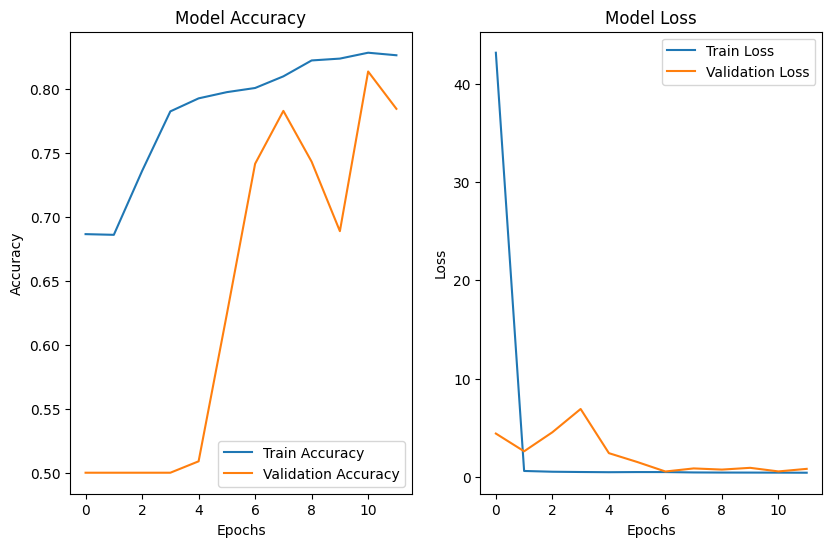

In [18]:
import matplotlib.pyplot as plt

# Ensure training completed before running this
if 'history' in globals():  # Check if history exists
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 3, 1)  # (rows, columns, index)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
else:
    print("Error: Model training has not been completed yet. Run model.fit() first.")


In [19]:
class_names = ['Forged', 'Authentic']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Prediction: Authentic
Confidence:  0.08%
--------------------------------------------------------------------------------------------------------------


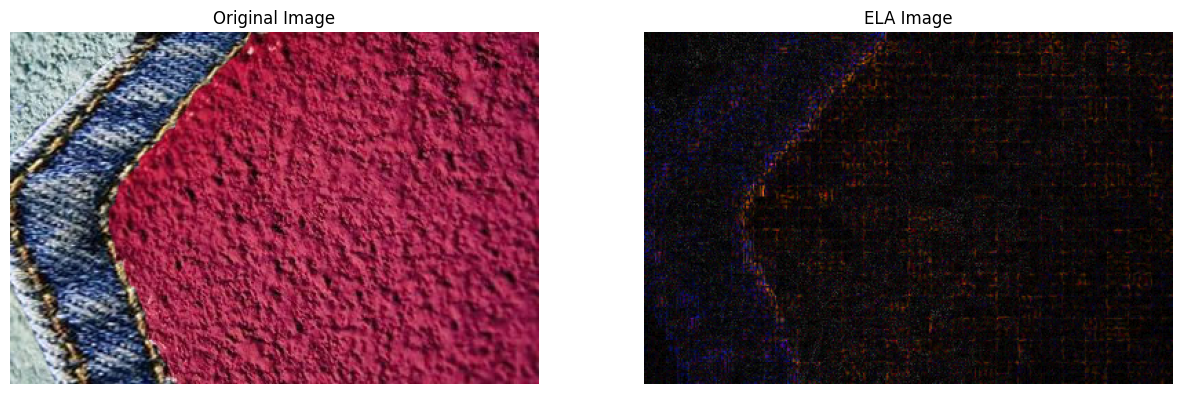

In [20]:
test_image_path = "/kaggle/input/casia-dataset/CASIA2/Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg"    # test image path
image = Image.open(test_image_path)
test_image = prepare_image(image)
test_image = test_image.reshape(-1, 256, 256, 1)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(image,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if np.any(y_pred <= 0.5):
    print(f'Confidence:  {(1 - y_pred[0][0]) * 100:0.2f}%')
else:
    print(f'Confidence:  {y_pred[0][0] * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: Forged
Confidence:  99.87%
--------------------------------------------------------------------------------------------------------------


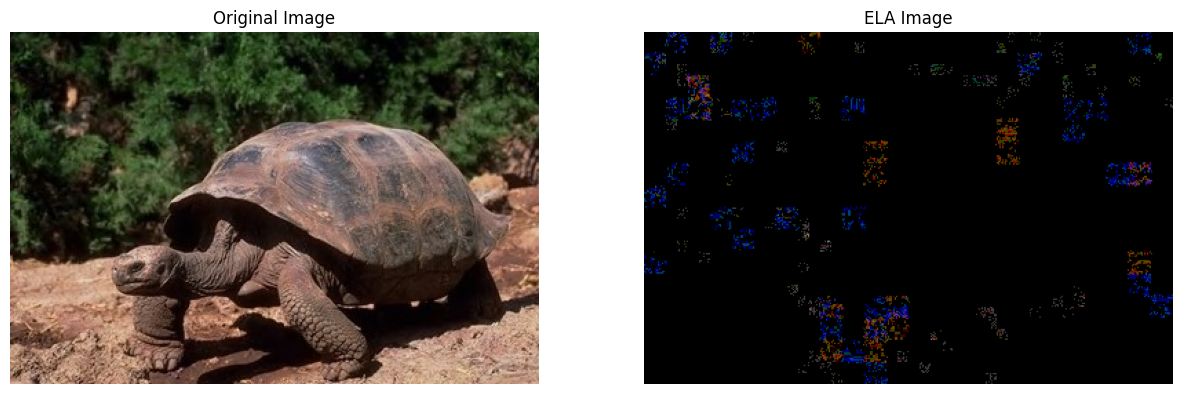

In [21]:
test_image_path = "/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_00003.jpg"    # test image path
image = Image.open(test_image_path)
test_image = prepare_image(image)
test_image = test_image.reshape(-1, 256, 256, 1)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(image,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if np.any(y_pred <= 0.5):
    print(f'Confidence:  {(1 - y_pred[0][0]) * 100:0.2f}%')
else:
    print(f'Confidence:  {y_pred[0][0] * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')